In [3]:
!wget https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip


--2025-12-11 16:57:11--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  20.1MB/s    in 3.9s    

2025-12-11 16:57:15 (19.8 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [5]:
import pandas as pd

df = pd.read_csv("training.1600000.processed.noemoticon.csv",
                 encoding="ISO-8859-1", header=None)
df

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [1]:
# =============================================
#  STEP 1 — DOWNLOAD SENTIMENT140 (NO KAGGLE)
# =============================================
!wget https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

# =============================================
#  STEP 2 — IMPORTS
# =============================================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

# =============================================
#  STEP 3 — LOAD DATA
# =============================================
df = pd.read_csv(
    "training.1600000.processed.noemoticon.csv",
    encoding="ISO-8859-1",
    header=None
)

df = df[[0, 5]]
df.columns = ["label", "text"]
df["label"] = df["label"].replace({4: 1})    # Convert 4 → 1 (positive)

# Sample 15k for Colab speed
df = df.sample(15000, random_state=42).reset_index(drop=True)

# =============================================
#  STEP 4 — CLEANING FUNCTION
# =============================================
pattern = re.compile(r"(?:\@|https?\://)\S+|[^\w\s#]")
lemm = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = str(text).lower()
    text = pattern.sub("", text)
    tokens = text.split()
    tokens = [lemm.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

df["clean"] = df["text"].apply(preprocess)

train = df.sample(frac=0.8, random_state=1)
val = df.drop(train.index)

# =============================================
#  STEP 5 — TOKENIZER FOR GRU / CNN
# =============================================
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train["clean"])

vocab_size = len(tokenizer.word_index) + 1
max_len = 80

X_train = pad_sequences(tokenizer.texts_to_sequences(train["clean"]), maxlen=max_len)
X_val   = pad_sequences(tokenizer.texts_to_sequences(val["clean"]), maxlen=max_len)

y_train = train["label"].values
y_val   = val["label"].values

# =============================================
#  STEP 6 — MODEL 1: GRU
# =============================================
def build_gru():
    model = Sequential([
        Embedding(vocab_size, 50),
        GRU(64),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

gru = build_gru()
gru.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)
gru_pred = (gru.predict(X_val) >= 0.5).astype(int)

# =============================================
#  STEP 7 — MODEL 2: TextCNN
# =============================================
def build_cnn():
    model = Sequential([
        Embedding(vocab_size, 50),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

cnn = build_cnn()
cnn.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)
cnn_pred = (cnn.predict(X_val) >= 0.5).astype(int)

# =============================================
#  STEP 8 — MODEL 3: DistilBERT (Fast Training)
# =============================================
bert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = bert_tokenizer(
            texts.tolist(),
            padding="max_length",
            truncation=True,
            max_length=64,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_ds = TweetDataset(train["clean"], train["label"].values)
val_ds   = TweetDataset(val["clean"], val["label"].values)

train_loader = DataLoader(train_ds, batch_size=12, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=12)

device = "cuda" if torch.cuda.is_available() else "cpu"

bert = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)

optimizer = torch.optim.Adam(bert.parameters(), lr=2e-5)

# FAST TRAIN — only a few batches
bert.train()
for i, batch in enumerate(train_loader):
    if i > 30: break
    optimizer.zero_grad()
    for k in batch:
        batch[k] = batch[k].to(device)
    output = bert(**batch)
    loss = output.loss
    loss.backward()
    optimizer.step()

# EVALUATION
bert.eval()
bert_preds = []
with torch.no_grad():
    for batch in val_loader:
        for k in batch:
            batch[k] = batch[k].to(device)
        out = bert(**batch)
        preds = torch.argmax(out.logits, dim=1).cpu().numpy()
        bert_preds.extend(preds)

bert_preds = np.array(bert_preds)

# =============================================
#  STEP 9 — METRICS
# =============================================
def show_metrics(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))

show_metrics("GRU", y_val, gru_pred)
show_metrics("TextCNN", y_val, cnn_pred)
show_metrics("DistilBERT", y_val, bert_preds)

# =============================================
#  STEP 10 — SAVE RESULTS
# =============================================
out = pd.DataFrame({
    "text": val["text"],
    "label": y_val,
    "gru_pred": gru_pred.flatten(),
    "cnn_pred": cnn_pred.flatten(),
    "bert_pred": bert_preds
})

out.to_csv("model_comparison.csv", index=False)
print("\nSaved model_comparison.csv")


--2025-12-11 16:58:54--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  10.6MB/s    in 7.5s    

2025-12-11 16:59:02 (10.4 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


2025-12-11 16:59:06.861271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765472347.051072      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765472347.110507      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1765472380.473301      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1765472383.041010     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6039 - loss: 0.6504 - val_accuracy: 0.7200 - val_loss: 0.5464
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


I0000 00:00:1765472387.675467     108 service.cc:148] XLA service 0x7aad32123ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765472387.675998     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 62/300 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4927 - loss: 0.6931

I0000 00:00:1765472389.207023     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5914 - loss: 0.6598 - val_accuracy: 0.7142 - val_loss: 0.5487
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== GRU ===
Accuracy : 0.725
Precision: 0.723667100130039
Recall   : 0.735624586913417
F1 Score : 0.7295968534906588

=== TextCNN ===
Accuracy : 0.713
Precision: 0.6926713947990544
Recall   : 0.7746199603436881
F1 Score : 0.7313572542901716

=== DistilBERT ===
Accuracy : 0.6426666666666667
Precision: 0.7078228086710651
Recall   : 0.4963648380700595
F1 Score : 0.5835275835275835

Saved model_comparison.csv


In [2]:
# ---- METRICS ----
metrics_table = pd.DataFrame({
    "Model": ["GRU", "CNN", "DistilBERT"],
    "Accuracy": [
        accuracy_score(y_val, gru_pred),
        accuracy_score(y_val, cnn_pred),
        accuracy_score(y_val, bert_preds)
    ],
    "Precision": [
        precision_score(y_val, gru_pred),
        precision_score(y_val, cnn_pred),
        precision_score(y_val, bert_preds)
    ],
    "Recall": [
        recall_score(y_val, gru_pred),
        recall_score(y_val, cnn_pred),
        recall_score(y_val, bert_preds)
    ],
    "F1 Score": [
        f1_score(y_val, gru_pred),
        f1_score(y_val, cnn_pred),
        f1_score(y_val, bert_preds)
    ]
})

print("===== MODEL PERFORMANCE SUMMARY =====")
display(metrics_table)


===== MODEL PERFORMANCE SUMMARY =====


,Model,Accuracy,Precision,Recall,F1 Score
0,GRU,0.725000,0.723667,0.735625,0.729597
1,CNN,0.713000,0.692671,0.774620,0.731357
2,DistilBERT,0.642667,0.707823,0.496365,0.583528


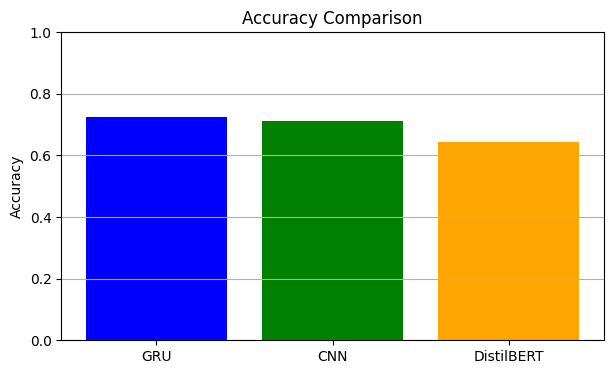

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

plt.figure(figsize=(7,4))
plt.bar(
    ["GRU", "CNN", "DistilBERT"],
    metrics_table["Accuracy"],
    color=["blue", "green", "orange"]
)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(axis="y")
plt.show()
